$$
\renewcommand{PDut}{\frac{\partial u}{\partial t}}
\renewcommand{PDuS}{\frac{\partial u}{\partial S}}
\renewcommand{PDuSS}{\frac{\partial ^2u}{\partial S^2}}
\renewcommand{eps}{\varepsilon}
$$
$\newcommand{\a}{\alpha} \newcommand{\s}{\sigma} \newcommand{\half}{\frac{1}{2}} \newcommand{\F}{\mathcal{F}} \newcommand{\P}{\mathbb{P}} \newcommand{\par}{\partial} \newcommand{\R}{\mathbb{R}} \newcommand{\argmin}{\arg\!\min} \newcommand{\E}{\mathbb E} \newcommand{\lb}{\left [} \newcommand{\rb}{\right ]} \newcommand{\U}{\mathcal{U}}$


In [21]:
import numpy as np
import matplotlib.pyplot as plt

The usual PDE representation of American option price is given by the variational inequality

$$  
    \max \left(\par_t u + \mathcal{L}u, g(x) - u \right) = 0, \quad u(T, x) = g(x) 
$$

which will be used as as the benchmark method for American option pricing. Now, we introduce the nonlinear PDE representation of America option

$$
    \par_t u + \mathcal{L}u + (\mathcal{L}g)^-\mathbb{1}_{\{u(t,x)=g(x)\}} = 0, \quad u(T, x) = g(x)
$$


For put option payoff is given by

$$
    g(x) = (k-x)^+ = 
            \begin{cases}
               k-x &\quad \text{for } x \leq k  \\
               0 &\quad\text{otherwise.} \\ 
             \end{cases}
$$

which is not differentiable at $x = k$. Hence, we will consider the approximation

$$
    g_\eps(x) = 
        \begin{cases}
           k-x &\quad \text{for } x < k - \eps  \\
           \frac{-(x - (k+\eps))^2}{-4\eps} &\quad \text{for } k-\eps \leq x \leq k+\eps \\
           0 &\quad\text{for}  x \geq k + \eps \\ 
         \end{cases}
$$

To visualize our payoff function,

In [22]:
def g(x, K):
    return np.maximum(K - x, 0)

def g_eps(x, K, eps):
    a = K - eps
    b = K + eps
    val1 = np.where(x < a, K-x, 0)
    val2 = np.where((x <= b) & (a <= x), -((x-b)**2)/(-4*eps), 0)
    val3 = np.where(x >= b, 0, 0)
    
    return val1 + val2 + val3

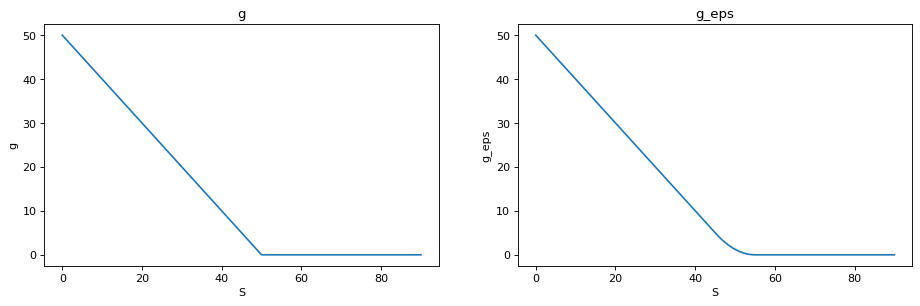

In [23]:
K = 50
xs = np.linspace(0, 90, 1000)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), dpi=80)
ax1.set_title('g')
ax2.set_title('g_eps')

ax1.plot(xs, g(xs, K=K))
ax2.plot(xs, g_eps(xs, K=K, eps=0.1*K))

ax1.set_xlabel("S")
ax2.set_xlabel("S")
ax1.set_ylabel("g")
ax2.set_ylabel("g_eps")
plt.show()

In [31]:
class BS_FDM_implicit:
    def __init__(self,
                 r,
                 sigma,
                 maturity,
                 Smin,
                 Smax,
                 Fl,
                 Fu,
                 payoff,
                 nt,
                 ns):
        self.r = r
        self.sigma = sigma
        self.maturity = maturity

        self.Smin = Smin
        self.Smax = Smax
        self.Fl = Fl
        self.Fu = Fu

        self.nt = nt
        self.ns = ns

        self.dt = float(maturity) / nt
        self.dx = float(Smax - Smin) / (ns + 1)
        self.xs = Smin / self.dx

        self.u = np.empty((nt + 1, ns))
        self.u[0, :] = payoff

        # Building Coefficient matrix:
        A = sparse.lil_matrix((self.ns, self.ns))

        for j in range(0, self.ns):
            xd = j + 1 + self.xs
            sx = self.sigma * xd
            sxsq = sx * sx

            dtmp1 = self.dt * sxsq
            dtmp2 = self.dt * self.r
            A[j, j] = 1.0 + dtmp1 + dtmp2

            dtmp1 = -0.5 * dtmp1
            dtmp2 = -0.5 * dtmp2 * xd
            if j > 0:
                A[j, j - 1] = dtmp1 - dtmp2
            if j < self.ns - 1:
                A[j, j + 1] = dtmp1 + dtmp2

        self.A = linsolve.splu(A)
        self.rhs = np.empty((self.ns,))

        # Building bc_coef:
        nxl = 1 + self.xs
        sxl = self.sigma * nxl
        nxu = self.ns + self.xs
        sxu = self.sigma * nxu

        self.blcoef = 0.5 * self.dt * (- sxl * sxl + self.r * nxl)
        self.bucoef = 0.5 * self.dt * (- sxu * sxu - self.r * nxu)

    def solve(self):
        for i in range(0, self.nt):
            self.rhs[:] = self.u[i, :]
            self.rhs[0] -= self.blcoef * self.Fl[i]
            self.rhs[self.ns - 1] -= self.bucoef * self.Fu[i]
            self.u[i + 1, :] = self.A.solve(self.rhs)

            # since it's an american option
            # self.u[i + 1, :] = np.maximum(self.u[i + 1, :], self.u[0, :])
            # print(self.u[i + 1, :])
            # print(self.u[0, :])
            # print(np.maximum(self.u[i + 1, :], self.u[0, :]))

        return self.u